# Setup

In [14]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

# Sample corpus of text documents

In [15]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


# Simple text pre-processing

In [16]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [17]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

# Word Embeddings

## Load up sample corpus - Bible

In [18]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]

norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]

norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print("Orignal length:", len(bible))
print('\nTotal lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Orignal length: 30103

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


# CBOW Model

## Build Vocabulary

In [19]:
from keras.preprocessing import text
from keras.utils import np_utils
# from keras.preprocessing import sequence
from keras.utils import pad_sequences

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index
word2id

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


## Build (context_words, target_word) pair generator

In [20]:
window_size = 2 # context window size

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


## Build the CBOW model architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 100)            1242500   
                                                                 
 lambda_1 (Lambda)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 12425)             1254925   
                                                                 
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


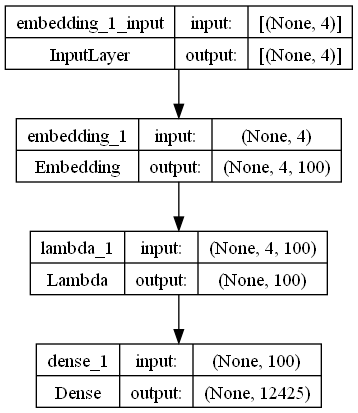

In [21]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
import tensorflow as tf

embed_size = 100

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

tf.keras.utils.plot_model(cbow, show_shapes=True)

## Train the model

In [ ]:
# for epoch in range(1, 2):
#     loss = 0.
#     i = 0
#     for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
#         i += 1
#         loss += cbow.train_on_batch(x, y)
#         if i % 100000 == 0:
#             print('Processed {} (context, word) pairs'.format(i))

#     print('Epoch:', epoch, '\tLoss:', loss)
#     print()

In [25]:
# how does one context target pair looks like
# list(generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size))[0]

(array([[   0,    0, 1154, 5766]]),
 array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [22]:
# total number of context target pairs
# len(list(generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size)))

373569

## Get Word Embeddings

In [ ]:
# weights = cbow.get_weights()[0]
# weights = weights[1:]
# print(weights.shape)

# pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

## Build a distance matrix to view the most similar words (contextually)

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances

# # compute pairwise distance matrix
# distance_matrix = euclidean_distances(weights)
# print(distance_matrix.shape)

# # view contextually similar words
# similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
#                    for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

# similar_words

# Skip-gram Model

## Build Vocabulary

In [23]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


## Build a skip-gram [(target, context), relevancy] generator

In [24]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(james (1154), bible (5766)) -> 1
(bible (5766), envy (2191)) -> 0
(bible (5766), king (13)) -> 1
(king (13), fellowservant (4621)) -> 0
(james (1154), king (13)) -> 1
(bible (5766), james (1154)) -> 1
(king (13), james (1154)) -> 1
(king (13), bible (5766)) -> 1
(james (1154), arose (382)) -> 0
(bible (5766), fried (6953)) -> 0


In [36]:
count = 0 
for item in skip_grams:
    count += len(item[1])

print("Total number of context target pairs: ", count)


Total number of context target pairs:  8988744


## Build the skip-gram model architecture

In [ ]:
from keras.models import Model
from keras.layers import Dense, Embedding, Reshape, Input, dot

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding')

word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)
context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary())

tf.keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
# for epoch in range(1, 2):
#     loss = 0
#     for i, elem in enumerate(skip_grams):
#         pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
#         pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
#         labels = np.array(elem[1], dtype='int32')
#         X = [pair_first_elem, pair_second_elem]
#         Y = labels
#         if i % 10000 == 0:
#             print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
#         loss += model.train_on_batch(X,Y)  

#     print('Epoch:', epoch, 'Loss:', loss)

## Get word embeddings

In [ ]:
# merge_layer = model.layers[0]
# word_model = merge_layer.layers[0]
# word_embed_layer = word_model.layers[0]
# weights = word_embed_layer.get_weights()[0][1:]

# print(weights.shape)
# pd.DataFrame(weights, index=id2word.values()).head()

## Build a distance matrix to view the most similar words (contextually)

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances

# distance_matrix = euclidean_distances(weights)
# print(distance_matrix.shape)

# similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
#                    for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

# similar_words

## Visualize word embeddings

In [ ]:
# from sklearn.manifold import TSNE

# words = sum([[k] + v for k, v in similar_words.items()], [])
# words_ids = [word2id[w] for w in words]
# word_vectors = np.array([weights[idx] for idx in words_ids])
# print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

# tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
# np.set_printoptions(suppress=True)
# T = tsne.fit_transform(word_vectors)
# labels = words

# plt.figure(figsize=(14, 8))
# plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
# for label, x, y in zip(labels, T[:, 0], T[:, 1]):
#     plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Leveraging gensim for building a word2vec model

In [48]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, epochs =50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'glory', 'worldly', 'us', 'established'],
 'jesus': ['messias', 'peter', 'nathanael', 'iscariot', 'immediately'],
 'noah': ['shem', 'japheth', 'ham', 'kenan', 'enosh'],
 'egypt': ['bondage', 'pharaoh', 'egyptians', 'flowing', 'rid'],
 'john': ['james', 'baptist', 'peter', 'galilee', 'andrew'],
 'gospel': ['christ', 'preach', 'teaching', 'faith', 'afflictions'],
 'moses': ['congregation', 'children', 'aaron', 'joshua', 'sinai'],
 'famine': ['pestilence', 'peril', 'blasting', 'mildew', 'noisome']}

## Visualizing word embeddings

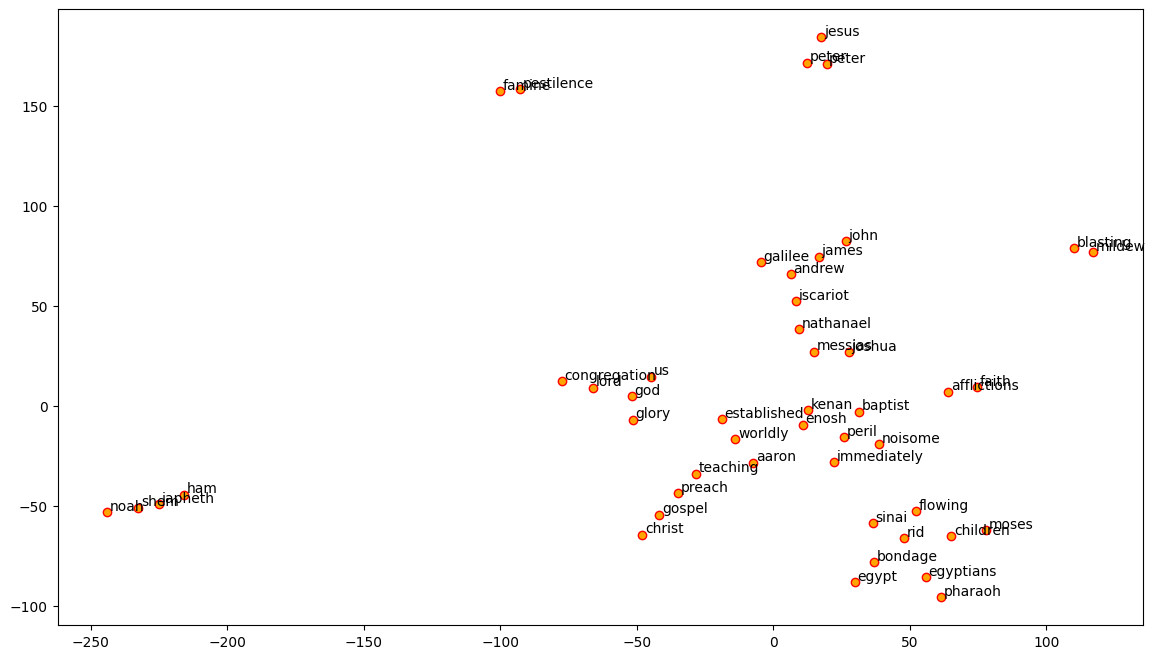

In [62]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2, init='random', learning_rate='auto')
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Applying the word2vec model on our sample corpus

In [69]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                              window=window_context, min_count=min_word_count,
                              sample=sample, epochs=1000)

## Visualize word embeddings

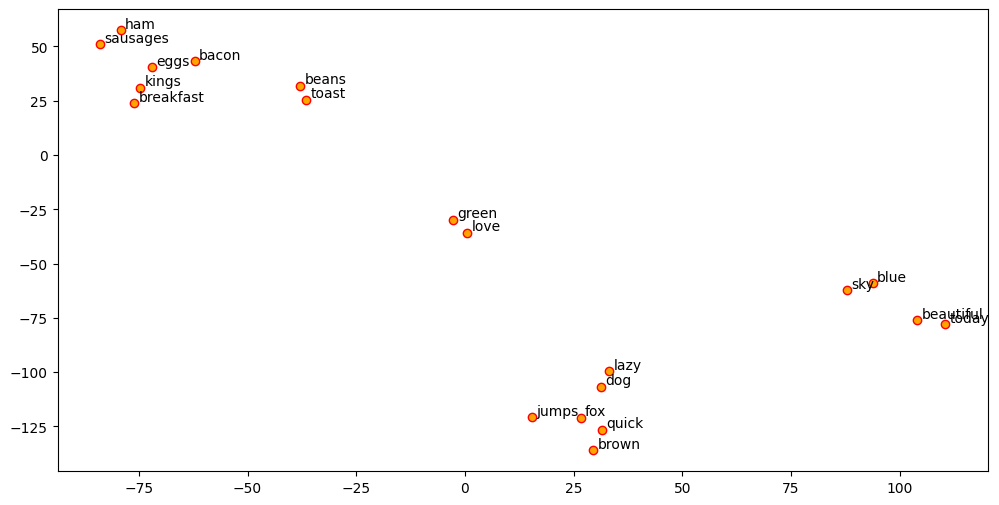

In [70]:
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2, init='random', learning_rate='auto')
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Sample word embedding

In [68]:
w2v_model.wv['sky']

array([-0.04728324, -0.12755214,  0.22039331,  0.0514324 ,  0.22821583,
        0.0906278 ,  0.6747984 ,  0.34137458, -0.39175797,  0.18754213],
      dtype=float32)

## Build framework for getting document level embeddings

In [83]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [84]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,-0.046919,-0.114555,0.174332,-0.009610,0.265337,0.119158,0.617980,0.243350,-0.354558,0.154406
1,-0.040002,-0.140229,0.194009,-0.034302,0.330927,0.155529,0.621423,0.266141,-0.358868,0.212731
2,-0.113757,0.020641,0.038455,-0.130083,0.485608,0.175211,0.610569,0.285924,-0.347641,0.305237
3,-0.079747,-0.311121,0.272325,0.033560,0.781899,0.398733,1.087119,0.432049,-0.524238,0.524417
4,-0.063210,-0.287647,0.269406,0.035803,0.724506,0.385318,0.999811,0.428215,-0.516961,0.503217
5,-0.085155,0.002658,0.049519,-0.108578,0.473165,0.167434,0.621786,0.303488,-0.384285,0.281068
6,-0.039978,-0.112231,0.171709,-0.016110,0.238415,0.114230,0.586957,0.238967,-0.348816,0.166437
7,-0.106895,0.024301,0.044732,-0.134513,0.505991,0.171659,0.625392,0.313173,-0.380634,0.309414


## Clustering with word embeddings

In [85]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, e...",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beaut...,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2


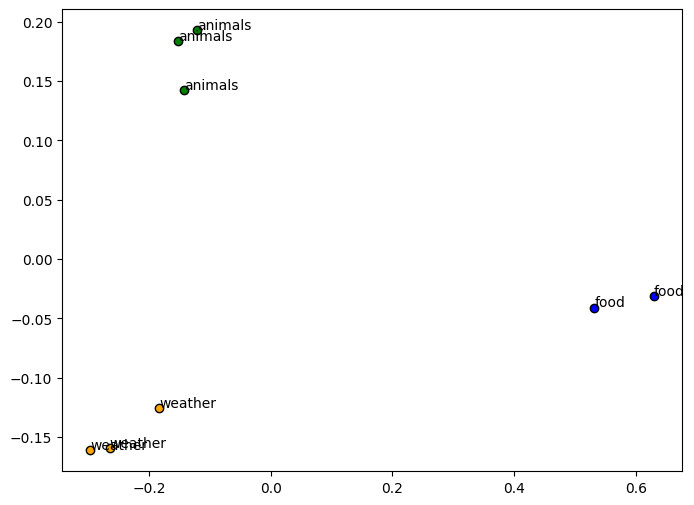

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

# The GloVe Model

In [118]:
import spacy

nlp = spacy.load('en_core_web_lg')

print("Info about model:")
print(nlp.meta['vectors'])

Info about model:
{'width': 300, 'vectors': 514157, 'keys': 514157, 'name': 'en_vectors', 'mode': 'default'}


## Visualize GloVe word embeddings

In [119]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words).head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
ham,0.44278,-4.11410,1.2356,4.1873,1.62440,-1.26010,-1.64350,-0.900330,-1.24150,0.86724,...,3.65740,-1.6391,3.9030,-6.56120,3.67370,-1.20580,3.819300,3.60500,3.6386,4.03620
breakfast,-0.68660,-1.72670,-3.0013,-1.1101,1.83890,-3.07660,-0.23369,1.013300,-2.02340,3.03370,...,1.17360,-2.7272,1.5723,-2.42900,-1.52760,0.98387,-0.098775,2.95160,-1.6079,2.54120
beans,0.93585,-0.45081,-4.9560,2.2548,1.21050,-1.66760,0.87959,0.004286,-4.16780,3.96000,...,3.11660,1.1007,4.0496,-0.97496,-5.12730,-0.63158,6.890100,-0.34744,2.4419,0.90073
beautiful,-0.18931,-0.70682,-3.1731,-4.1407,0.70243,-0.69255,2.34870,1.708300,-0.92738,3.48430,...,0.59424,2.1492,3.2738,-1.28600,1.95050,-0.67481,-0.930960,3.28140,-5.5232,-0.31346
blue,-4.31020,2.57060,-3.4722,2.5205,-1.11040,-5.10140,-1.48120,4.655900,0.38365,2.47720,...,-5.25050,4.2053,2.9249,-0.93310,0.89071,6.85240,0.075678,1.07370,-2.9600,-0.42209


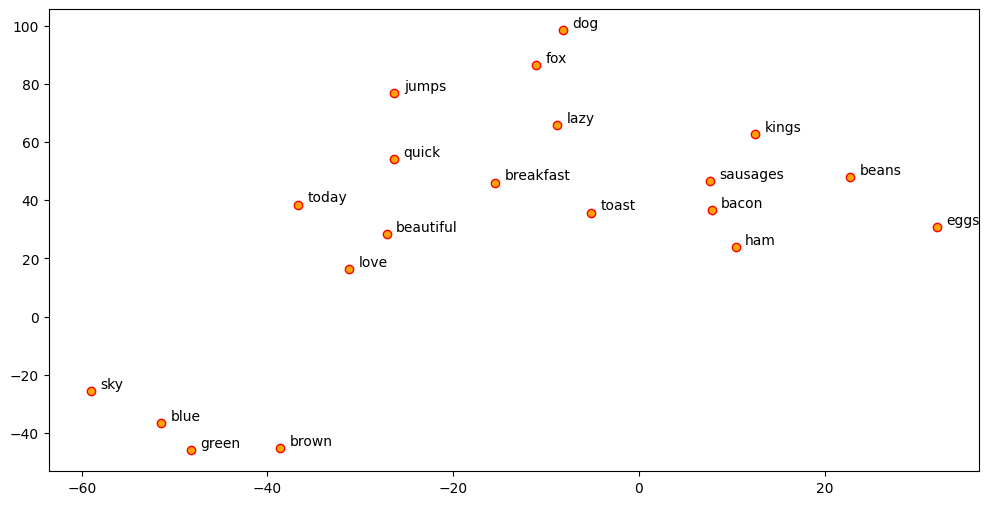

In [120]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3, init='random', learning_rate='auto')
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Cluster documents with GloVe Embeddings

In [128]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, e...",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beaut...,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2
